# Dataset Preparation for First ICU Prediction

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
import pickle
import torch
from pathlib import Path
from tqdm import tqdm_notebook as tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader

from cnn.cnn_classifier.dataset import NoteDataset
from cnn.cnn_classifier.model import NoteClassifier
from cnn.args import args as cnn_args

from utils.embeddings import PretrainedEmbeddings
from utils.metrics import BinaryAvgMetrics
from utils.plots import *
from args import args

## 100 Run Performance Results

In [ ]:
models = list(args.bc_threshold.keys())

bams = {}

for model in models:
  with open(args.workdir/model/'preds.pkl', 'rb') as f:
    targs = pickle.load(f)
    preds = pickle.load(f)
    probs = pickle.load(f)
    
  bams[model] = BinaryAvgMetrics(targs, preds, probs)

all_metrics = {}

for key in bams.keys():
  all_metrics[key] = []
  for i in range(len(bams[key].get_avg_metrics())):
    all_metrics[key].append(bams[key].get_avg_metrics().iloc[i]['Value'])

metrics = pd.DataFrame(all_metrics, index=['sensitivity', 'specificity', 'ppv', 'auroc', 'npv', 'f1'])
metrics

### Model Plots

In [ ]:
model = 'cnn'
bams[model].get_avg_metrics()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_mean_roc(ax, bams[model].targs, bams[model].probs)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bams[model].cm_avg, classes=['not imminent', 'imminent'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bams[model].cm_avg, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()

## Temporal Performance Analysis

In [3]:
df = pd.read_csv(args.dataset_csv, parse_dates=['admittime', 'dischtime', 'intime', 'charttime'])
df['relative_charttime'] = (df['charttime'] - df['intime'])
print(df.shape)
print(df.columns)

(75273, 22)
Index(['subject_id', 'hadm_id', 'icustay_id', 'admission_type', 'admittime',
       'dischtime', 'intime', 'charttime', 'adm_icu_period',
       'chart_icu_period', 'chartinterval', 'ethnicity', 'dob', 'gender',
       'admission_age', 'category', 'description', 'text', 'class_label',
       'note', 'scispacy_note', 'relative_charttime'],
      dtype='object')


In [4]:
interval=12
cutoff=20

### Logistic Regression

In [21]:
model = 'lr'

with open(args.workdir/model/'all_data_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True,\
                              ngram_range=(2,2), vocabulary=vocabulary)

df['prob'] = clf.predict_proba(vectorizer.fit_transform(df['scispacy_note']))[:, 1]

In [22]:
prob = clf.predict_proba(vectorizer.fit_transform(df['scispacy_note']))[:, 1]

In [23]:
prob.shape

(75273,)

In [24]:
type(prob)

numpy.ndarray

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df, args.bc_threshold[model], cutoff=cutoff, interval=interval, granularity=2)

### Random Forest

In [ ]:
model = 'rf'

with open(args.workdir/model/'all_data_model.pkl', 'rb') as f:
  clf = pickle.load(f)
  vocabulary = pickle.load(f)
  
vectorizer = TfidfVectorizer(min_df=3, analyzer=str.split, sublinear_tf=True,\
                              ngram_range=(2,2), vocabulary=vocabulary)  

df['prob'] = clf.predict_proba(vectorizer.fit_transform(df['scispacy_note']))[:, 1]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df, args.bc_threshold[model], cutoff=cutoff, interval=interval, granularity=2)

### CNN

In [5]:
model = 'cnn'
bs = 256

In [6]:
with open(args.workdir/model/'full_data_model.pkl', 'rb') as f:
  state_dict = pickle.load(f)

In [7]:
ds = NoteDataset.load_data_and_vectorizer_from_file(df, cnn_args.workdir)
dl = DataLoader(ds, bs)
itr = iter(dl)

In [8]:
pe = PretrainedEmbeddings.from_file(cnn_args.emb_path)
pe.make_custom_embeddings(ds.vectorizer.vocab.idx_token_bidict.values())

In [9]:
classifier = NoteClassifier(cnn_args.emb_sz, len(ds.vectorizer.vocab), cnn_args.n_channels,\
                            cnn_args.hidden_dim, 1, dropout_p=cnn_args.dropout_p,\
                            emb_dropout=cnn_args.emb_dropout, pretrained=pe.custom_embeddings)

classifier.load_state_dict(state_dict);

In [10]:
preds = []

In [13]:
for x, _ in tqdm(dl):
  preds.append(torch.sigmoid(classifier(x)).detach().numpy())

In [27]:
x,y = next(itr)
preds.append(torch.sigmoid(classifier(x)).detach().numpy())

In [28]:
len(preds)

2

In [14]:
prob = np.concatenate(preds)

In [20]:
np.save(cnn_args.workdir/'probabilities', prob)

In [21]:
df['prob'] = prob

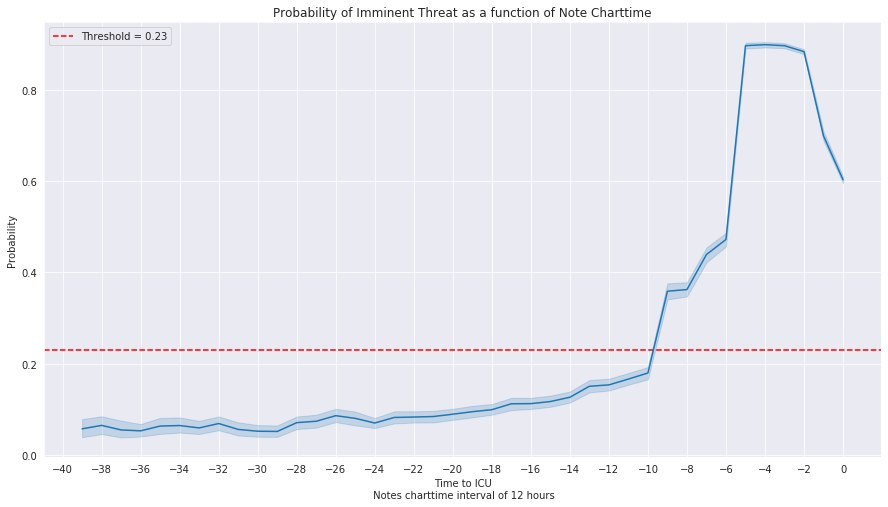

In [22]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df, args.bc_threshold[model], cutoff=cutoff, interval=interval, granularity=2)